# Modeling The Three Body Problem with Symmetries
In this project we sought to model the three body problem by incorporating different symmetries into the neural network. We use a couple of different methods for making predictions on the three body problem. First we try developing a Hamiltonian Neural Network [1] and train it to directly predict the acceleration and velocity at each time step. However, Hamiltonian ODEs rely on training using the ground truth of acceleration which we may not have access to. As a result we develop several Neural ODEs [2] to better model the data.

We would not recommend re-running some of these cells. The Hamiltonian Neural Networks only take about 3-4 minutes to run, but some of the Neural ODEs were trained for hours on the BYU super computer with much better GPUs. We have included several folders with simulations of the three body problem for various architectures.

Drop down to Neural ODEs and Latent Neural ODEs for the more impressive results.

## Literature Review
[1] Sam Greydanus, Misko Dzamba, & Jason Yosinski. (2019). Hamiltonian Neural Networks.

This works seeks to learn differential equations that model Hamiltonian systems. Many different systems can be fully characterized by the energy equation called the Hamiltonian. The Hamiltonian not only predicts the energy of a system but its derivatives predict both change in momentum and change in position. In this work, they train a neural network that predicts the hamiltonian of a system by backpropagating to make the partial derivatives of the network match the change in momentum and positions of the hamiltonian.

In their work they predict energies of several different systems: The ideal mass spring, ideal pendulum, and the real pendulum. They also try to model the two and three body problem but are unable to get very good results with the three body problem. We use portions of their code when generating the datasets for our three body problem.

[2] Ricky T. Q. Chen, Yulia Rubanova, Jesse Bettencourt, & David Duvenaud. (2019). Neural Ordinary Differential Equations.

This work proposes using ODE solvers as a version of residual connections for neural networks. The inspiration for this is that residual connections look a lot like forward euler integration. Their idea was to use feedforward neural network as the update equation in the ODE solver and then backpropagate through the ODE solver. However, backpropagating through an ODE solver can be very costly. So as a result, they propose an adjoint method that allows us to not have to differentiate all the way through the ODE solver and do backpropagation in $O(1)$ time.  Additionally, they model time series using a Latent Neural ODE that is able to filter out noise using a Variational Auto-Encoder.

In our work we do not use the adjoint method they propose. This is because we found it took much longer than just backpropagating through the solver initially.

## Hamiltonian Neural Networks
In this first section we explore trying to model the three body system with Hamiltonian Neural Networks

The basic idea between a Hamiltonian Neural Network is to train a neural network to match the Hamiltonian energy of a system. So given the state of a system $x$, $H(x)$ produces the total energy of the system. However, we do not train to model this directly, rather we train a neural network approximation $\hat H(x)$ where we run gradient descent on the derivatives of a neural network.

More formally the Hamiltonian of a system typically takes in two inputs: position $p$ and momentum $q$. The hamiltonian equations tell us that $\frac{\partial H}{\partial p}=\frac{\partial q}{\partial t}$ and $\frac{\partial H}{\partial q}=-\frac{\partial p}{\partial t}$. So during training time we calculate the MSE loss between $\frac{\partial \hat H}{\partial p}$ and $\frac{\partial q}{\partial t}$ in addition to $\frac{\partial \hat H}{\partial q}$ and $-\frac{\partial p}{\partial t}$ so that our approximation $\hat H$ in truth represents the hamiltonian. At test time we then set $\frac{\partial q}{\partial t}=\frac{\partial \hat H}{\partial p}$ and $\frac{\partial p}{\partial t}=-\frac{\partial\hat H}{\partial q}$ when running things through the ODE solver.

We have examples comparing the Hamiltonian method to just naively computing predictions and typically the Hamiltonian works much better.

In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from tqdm import tqdm
from scipy.integrate import odeint
from data import get_orbit,random_config,sample_orbits,sample_orbits_grouped
from scipy.integrate import odeint
from torchdiffeq import odeint as todeint
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import os.path


/home/dbrown68/.conda/envs/mainenv/envs/cnns3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Dataset generation and initialization
- The following code should take about ~10 minutes to run assuming you do not have the data already downloaded

In [2]:
class PlanetaryData(Dataset):
    def __init__(self, x, dxdt):
        self.x = x
        self.dxdt = dxdt
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        return self.x[idx], self.dxdt[idx]
fname = "smaller_dataset"
if not os.path.isfile(f"{fname}_x_coords.pt"):

    data,_ = sample_orbits(time_steps = 80,trials = 5000,t_span=[0,20])
    x = torch.tensor( data['coords'], requires_grad=True, dtype=torch.float32)
    # test_x = torch.tensor( data['test_coords'], requires_grad=True, dtype=torch.float32)
    dxdt = torch.Tensor(data['dcoords'])
    torch.save(x,f"{fname}_x_coords.pt")
    torch.save(dxdt,f"{fname}_dxdt_vals.pt")
else:
    x = torch.load(f"{fname}_x_coords.pt")
    dxdt = torch.load(f"{fname}_dxdt_vals.pt")
print(x.shape)

torch.Size([100000, 12])


In [3]:
dset = PlanetaryData(x,dxdt)
print(f"Dataset has {len(dset)} examples")
epochs = 4
batch_size  = 64
dloader = DataLoader(dset,batch_size,shuffle=True)

Dataset has 100000 examples


### No Symmetry model
Here is our first implementation of the model with no additional invariance or equivariances specified. We found that it generally did not have too much trouble converging, but usually did not produce very good results.

In [4]:
class HNN(torch.nn.Module):
    """Generic class to implement predicting the derivative of the three body system
    """
    def __init__(self, input_dim,nn_type="Hamiltonian"):
        super(HNN, self).__init__()
        output_dim = input_dim if nn_type == "Feedforward" else 1
        if nn_type == "Hamiltonian" or nn_type == "Feedforward":
            self.layers = nn.Sequential(nn.Linear(input_dim,200),
                                                  nn.Tanh(),
                                                  nn.Linear(200,200),
                                                  nn.Tanh(),
                                                  nn.Linear(200,output_dim))
        else:
            raise ValueError(f"{nn_type} is not a valid type please choose between Hamiltonian or Feedforward")
        self.nn_type = nn_type

        # We make a permutation matrix M to later permute the derivatives so our loss acheives:
        # dp/dt=-dH/dq, dq/dt=dH/dp
        M = torch.eye(input_dim)
        self.M = torch.cat([M[input_dim//2:], -M[:input_dim//2]]) 

    def forward(self, x):
        # We just pass it through the layers
        return self.layers(x)

    def time_derivative(self, x, t=None):
        """Returns the prediction of our function

        Args:
            x (torch.Tensor): The state of the system
            t (torch.Tensor, optional): The current time step. Defaults to None.
        """
        # IF we are just doing a feedforward we try to predict the derivatives directly
        if self.nn_type == "Feedforward":
            return self.layers(x)

        # Otherwise we calculate -dH/dq as our prediction for dp/dt and dH/dp as our prediction for dq/dt
        F2 = self.forward(x) 

        dF2 = torch.autograd.grad(F2.sum(), x, create_graph=True)[0] 
        hamiltonian_derivative = dF2 @ self.M.T

        return hamiltonian_derivative


### Loss and Training results
Below we visualize the loss over time. Interestingly, we see periodic spikes in the training loss. Additionally, the loss generally did not decrease very much indicating that this is a very hard problem to learn.

100%|██████████| 1563/1563 [04:50<00:00,  5.39it/s]


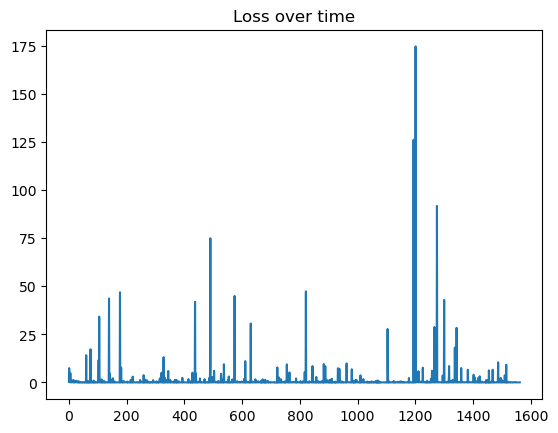

In [8]:
epochs = 1
model = HNN(12,"Feedforward")
opt = torch.optim.Adam(model.parameters(),1e-3)
losses = []
for epoch in range(epochs):
    for x,dxdt in tqdm(dloader):
        opt.zero_grad()
        pred = model.time_derivative(x)
        loss = F.mse_loss(pred,dxdt)
        loss.backward()
        opt.step()
        losses.append(loss.item())
plt.plot(losses)
plt.title("Loss over time")
plt.show()

### Visualizing results

/tmp/ipykernel_138063/19698718.py:57: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line.set_data(positions[i, j, 0], positions[i, j, 1])
/tmp/ipykernel_138063/19698718.py:61: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_approx.set_data(positions_approx[i, j, 0], positions_approx[i, j, 1])


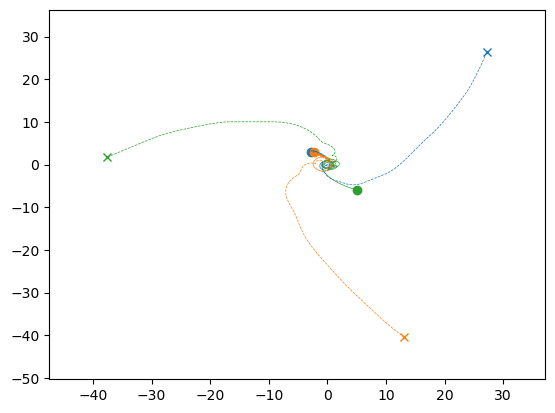

In [9]:
def model_update(t, state, model):
    state = state.reshape(-1,5)

    deriv = np.zeros_like(state)
    np_x = state[:,1:] # drop mass
    np_x = np_x.T.flatten()[None, :]
    x = torch.tensor( np_x, requires_grad=True, dtype=torch.float32)
    dx_hat = model.time_derivative(x)
    deriv[:,1:] = dx_hat.detach().data.numpy().reshape(4,3).T
    return deriv.reshape(-1)
num_steps = 1000
time_span = [0,40]
file_name = "vanilla_nn_example"
update_fn = lambda t, y0: model_update(t, y0, model)
state = random_config(nu=1e-2, min_radius=.9, max_radius=1.2)
v, settings = get_orbit(state, t_points=num_steps, t_span=time_span, update_fn=update_fn)
true_orbit,_ =get_orbit(state, t_points=num_steps, t_span=time_span)


positions_approx = v.transpose(2,0,1)[:,:,1:3]
positions= true_orbit.transpose(2,0,1)[:,:,1:3]
# Animation
# Animation setup
fig, ax = plt.subplots()
ax.set_xlim(-30, 30)
ax.set_ylim(-30, 30)

# Original positions visualized with 'o' markers and solid lines for trajectories
lines = [ax.plot([], [], 'o')[0] for _ in range(3)]
# Store colors for reuse with approximated trajectories
colors = [f"C{_}" for _ in range(3)]
trajectories = [ax.plot([], [], '-', linewidth=0.5, color=colors[_])[0] for _ in range(3)]

# Approximated positions visualized with 'x' markers and dotted lines for trajectories
# Use the same colors as the original trajectories
lines_approx = [ax.plot([], [], 'x', color=colors[_])[0] for _ in range(3)]
trajectories_approx = [ax.plot([], [], '--', linewidth=0.5, color=colors[_])[0] for _ in range(3)]

def init():
    for line in lines + lines_approx:
        line.set_data([], [])
    for traj in trajectories + trajectories_approx:
        traj.set_data([], [])
    return lines + trajectories + lines_approx + trajectories_approx

def animate(i):
    if len(positions[:i,:,0]) != 0:
        all_x = np.concatenate((positions[:i, :, 0].flatten(), positions_approx[:i, :, 0].flatten()))
        all_y = np.concatenate((positions[:i, :, 1].flatten(), positions_approx[:i, :, 1].flatten()))
        min_x, max_x = all_x.min() - 10, all_x.max() + 10
        min_y, max_y = all_y.min() - 10, all_y.max() + 10
        ax.set_xlim(min_x, max_x)
        ax.set_ylim(min_y, max_y)

    for j, (line, line_approx) in enumerate(zip(lines, lines_approx)):
        # Update original positions and trajectories
        line.set_data(positions[i, j, 0], positions[i, j, 1])
        trajectories[j].set_data(positions[:i, j, 0], positions[:i, j, 1])
        
        # Update approximated positions and trajectories
        line_approx.set_data(positions_approx[i, j, 0], positions_approx[i, j, 1])
        trajectories_approx[j].set_data(positions_approx[:i, j, 0], positions_approx[:i, j, 1])

    return lines + trajectories + lines_approx + trajectories_approx

# Assuming num_steps is defined
ani = animation.FuncAnimation(fig, animate, frames=num_steps, init_func=init, blit=True, interval=1)

# To save the animation
writergif = animation.PillowWriter(fps=30)
ani.save(f'{file_name}.gif', writer=writergif)

plt.show()

### Discussion
Typically both the Hamiltonian and Regular Neural Network did a very poor job at predicting position. This is most likely due to the chaotic nature of the system. Also, it seems like it is likely just memorizing individual paths. So when it comes to generalization, the model does not perform very well at all. It seems that at test time it is just averaging over paths learned.

Note that in these visualizations. The solid circles represent the actual trajectories and the crosses represent the predictions.

#### Feedforward Neural Network Version
![](examples/vanilla_nn_example.gif)

#### Hamiltonian Version
![](examples/hamiltonian_example_no_symmetry.gif)

# Equivariant Hamiltonian
We now implement a version of the Hamiltonian that has the added invariances/equivariances present in the problem.

The first invariance we add is invariance under translation. The velocities and accelerations of the three planets only depend on relative positions to one another. So to incorporate this invariance we pick on of the bodies and subtract the positions of the other two from this original. In this way we shift the planets closer to the origin. We can write this formally out as:
$$
NN(x)= \hat H(p2-p1,p3-p1,v1,v2,v3)
$$

We also add invariance under rotation. We note that while the actual positions and velocities should be equivariant, the actual hamiltonian is invariant under rotation. We can achieve rotational invarince by making the neural network a function of only the inner products between any two vectors. Written out this is:
$$
NN(x)=\hat H((\langle p_i,p_j \rangle)_{i,j=0}^2,(\langle q_i,q_j \rangle)_{i,j=0}^2,(\langle p_i,q_j \rangle)_{i,j=0}^2)
$$

Lastly, we add permutation invariance. This can be done by permuting the order in which the planets are fed into the model and then summing up the results.
$$
NN(x)=\sum_{(i,j,k)\in \sigma(3)}\hat H(p_i,p_j,p_k,q_i,q_j,q_k)
$$

We combine each of these three methods to produce the result below. 

In [10]:
from itertools import permutations
class EquivariantHNN(torch.nn.Module):
    """Generic class to implement predicting the derivative of the three body system
    """
    def __init__(self, input_dim):
        super(EquivariantHNN, self).__init__()
        self.layers = nn.Sequential(nn.Linear(15,200),
                                                  nn.Tanh(),
                                                  nn.Linear(200,200),
                                                  nn.Tanh(),
                                                  nn.Linear(200,200),
                                                  nn.Tanh(),
                                                  nn.Linear(200,200),
                                                  nn.Tanh(),
                                                  nn.Linear(200,1))

        # We make a permutation matrix M to later permute the derivatives so our loss acheives:
        # dp/dt=-dH/dq, dq/dt=dH/dp
        M = torch.eye(input_dim)
        self.M = torch.cat([M[input_dim//2:], -M[:input_dim//2]]) 

    def equivariant_fn(self,x):
        # print(x.shape)
        p1 = x[:,[True,False,False,True,False,False]+[False]*6]
        p2 = x[:,[False,True,False,False,True,False]+[False]*6]
        p3 = x[:,[False,False,True,False,False,True]+[False]*6]
        s1 = x[:,[False]*6+[True,False,False,True,False,False]]
        s2 = x[:,[False]*6+[False,True,False,False,True,False]]
        s3 = x[:,[False]*6+[False,False,True,False,False,True]]

        ps = [p1,p2,p3]
        ss = [s1,s2,s3]
        perms = permutations([1,2,0])

        # Cycling through each permutation ensures invariance under permutation
        outs = 0
        for perm in perms:
            # print(perm)
            p_1,p_2,p_3 = ps[perm[0]],ps[perm[1]],ps[perm[2]]
            s_1,s_2,s_3 = ss[perm[0]],ss[perm[1]],ss[perm[2]]

            # This ensures invariance under translation
            p_2 =p2- p_1
            p_3 = p_3-p_1

            # This ensures invariance under rotation
            units = [p_2,p_3,s_1,s_2,s_3]
            inner_prods = []
            for i  in range(len(units)):
                for j in range(i,len(units)):
                    inner_prods.append((units[i]*units[j]).sum(dim=-1))
            inner_prods = torch.dstack(inner_prods).squeeze(0)
            outs+= self.layers(inner_prods)
        return outs/6

    def forward(self, x):
        # We just pass it through the layers
        return self.equivariant_fn(x)

    def time_derivative(self, x, t=None):
        """Returns the prediction of our function

        Args:
            x (torch.Tensor): The state of the system
            t (torch.Tensor, optional): The current time step. Defaults to None.
        """

        # We calculate -dH/dq as our prediction for dp/dt and dH/dp as our prediction for dq/dt
        F2 = self.forward(x) 

        dF2 = torch.autograd.grad(F2.sum(), x, create_graph=True)[0] 
        hamiltonian_derivative = dF2 @ self.M.T

        return hamiltonian_derivative

### Loss and Training results
Below we plot the training loss over time of both the acceleration and velocity. This is done to figure out which component is harder for the model to learn.

100%|██████████| 1563/1563 [02:42<00:00,  9.62it/s]


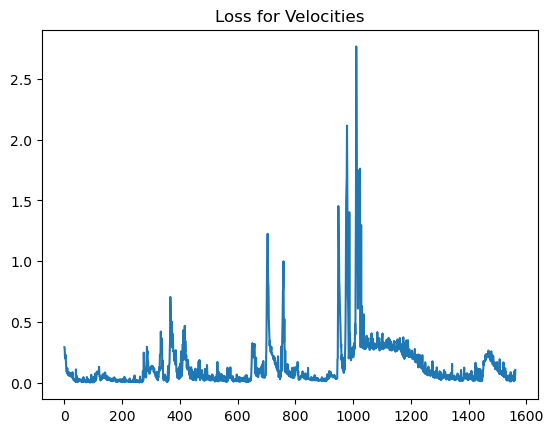

Text(0.5, 1.0, 'Loss for Accelerations')

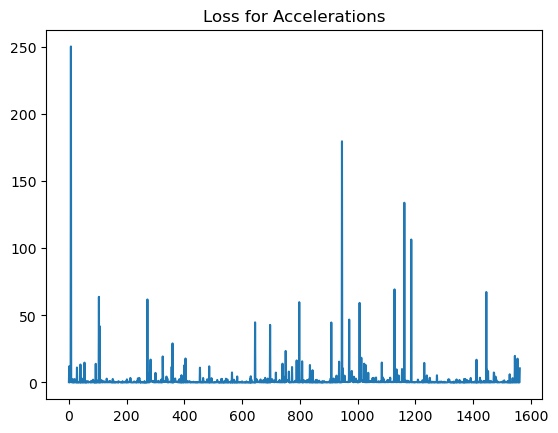

In [12]:
epochs = 1
model = EquivariantHNN(12)
opt = torch.optim.Adam(model.parameters(),1e-3)
losses1 = []
losses2 = []
for epoch in range(epochs):
    for x,dxdt in tqdm(dloader):
        opt.zero_grad()
        pred = model.time_derivative(x)
        loss1 = F.mse_loss(pred[:,:3],dxdt[:,:3])
        loss2= F.mse_loss(pred[:,3:],dxdt[:,3:])
        loss = loss1+loss2**2
        loss.backward()
        opt.step()
        losses1.append(loss1.item())
        losses2.append(loss2.item())
plt.plot(losses1)
plt.title("Loss for Velocities")
plt.show()
plt.plot(losses2)
plt.title("Loss for Accelerations")

/tmp/ipykernel_138063/1772924157.py:57: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line.set_data(positions[i, j, 0], positions[i, j, 1])
/tmp/ipykernel_138063/1772924157.py:61: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_approx.set_data(positions_approx[i, j, 0], positions_approx[i, j, 1])


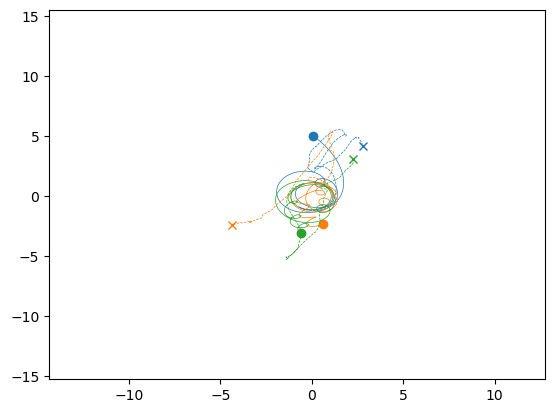

In [13]:
def model_update(t, state, model):
    state = state.reshape(-1,5)

    deriv = np.zeros_like(state)
    np_x = state[:,1:] # drop mass
    np_x = np_x.T.flatten()[None, :]
    x = torch.tensor( np_x, requires_grad=True, dtype=torch.float32)
    dx_hat = model.time_derivative(x)
    deriv[:,1:] = dx_hat.detach().data.numpy().reshape(4,3).T
    return deriv.reshape(-1)
num_steps = 500
time_span = [0,40]
file_name = "equivariant_hnn"
update_fn = lambda t, y0: model_update(t, y0, model)
state = random_config(nu=1e-2, min_radius=.9, max_radius=1.2)
v, settings = get_orbit(state, t_points=num_steps, t_span=time_span, update_fn=update_fn)
true_orbit,_ =get_orbit(state, t_points=num_steps, t_span=time_span)


positions_approx = v.transpose(2,0,1)[:,:,1:3]
positions= true_orbit.transpose(2,0,1)[:,:,1:3]
# Animation
# Animation setup
fig, ax = plt.subplots()
ax.set_xlim(-30, 30)
ax.set_ylim(-30, 30)

# Original positions visualized with 'o' markers and solid lines for trajectories
lines = [ax.plot([], [], 'o')[0] for _ in range(3)]
# Store colors for reuse with approximated trajectories
colors = [f"C{_}" for _ in range(3)]
trajectories = [ax.plot([], [], '-', linewidth=0.5, color=colors[_])[0] for _ in range(3)]

# Approximated positions visualized with 'x' markers and dotted lines for trajectories
# Use the same colors as the original trajectories
lines_approx = [ax.plot([], [], 'x', color=colors[_])[0] for _ in range(3)]
trajectories_approx = [ax.plot([], [], '--', linewidth=0.5, color=colors[_])[0] for _ in range(3)]

def init():
    for line in lines + lines_approx:
        line.set_data([], [])
    for traj in trajectories + trajectories_approx:
        traj.set_data([], [])
    return lines + trajectories + lines_approx + trajectories_approx

def animate(i):
    if len(positions[:i,:,0]) != 0:
        all_x = np.concatenate((positions[:i, :, 0].flatten(), positions_approx[:i, :, 0].flatten()))
        all_y = np.concatenate((positions[:i, :, 1].flatten(), positions_approx[:i, :, 1].flatten()))
        min_x, max_x = all_x.min() - 10, all_x.max() + 10
        min_y, max_y = all_y.min() - 10, all_y.max() + 10
        ax.set_xlim(min_x, max_x)
        ax.set_ylim(min_y, max_y)

    for j, (line, line_approx) in enumerate(zip(lines, lines_approx)):
        # Update original positions and trajectories
        line.set_data(positions[i, j, 0], positions[i, j, 1])
        trajectories[j].set_data(positions[:i, j, 0], positions[:i, j, 1])
        
        # Update approximated positions and trajectories
        line_approx.set_data(positions_approx[i, j, 0], positions_approx[i, j, 1])
        trajectories_approx[j].set_data(positions_approx[:i, j, 0], positions_approx[:i, j, 1])

    return lines + trajectories + lines_approx + trajectories_approx

# Assuming num_steps is defined
ani = animation.FuncAnimation(fig, animate, frames=num_steps, init_func=init, blit=True, interval=1)

# To save the animation
writergif = animation.PillowWriter(fps=30)
ani.save(f'{file_name}.gif', writer=writergif)

plt.show()

### Discussion
The Equivariant Hamiltonian acheived much better results on test data than the non equivariant versions. It could predict an accurate path for the first second or so. However, once we got past the initial couple of seconds it would completely diverge from the true path and not seem to model accurate paths at all.

Note that in these visualizations. The solid circles represent the actual trajectories and the crosses represent the predictions.

![](examples/equivariant_hnn.gif)

# Neural ODE
A Neural ODE works by treating a Neural Network $f$ as a derivative in some differential equation. We then use an ODE solver to integrate forward in time and then backpropagate through the ODE solver. This can be viewed as somehow smoothing or continuizing the normal feedforward network since we can arbitrarily choose the step size.

# Latent Neural ODE 
The Latent Neural ODE is similar in spirit to the normal Neural ODE except we create the space in which to run the ODE solver. To do this we train an autoencoder that maps between the observation space $(p,q)$ and some latent space of arbitrary dimension. During train time we first map the initial observation $x$ to the latent space via the encoder $z=\text{encoder}(x)$. We then run the ODE solver in this latent space to produce a trajectory of examples $z_1,...z_n$. We then convert each of these back to normal coordinates using the decoder $x_1=\text{decoder}(z_1),...,x_n=\text{decoder}(z_n)$

The original motivation in [2] for this method was to deal with noisy data. However, in our experiments we found that training the autoencoder to be probabilistic (noise resistant) instead of exact (not noise resistant) degraded performance. This could be because our data is not super noisy to begin with. However, introducing the latent dimension did improve performance because it seemed like it gave the neural network more expressibility in the high dimensional space.

Again we would not recommend running these locally, unless you have a high end GPU.

### Non-equivariant version
Below we implement a Neural ODE that does not contain any symmetries.

In [ ]:
from matplotlib.animation import FuncAnimation, PillowWriter
from data import sample_orbits_grouped
from torchdiffeq import odeint as todeint
import torch.nn.functional as F

class LatentODEfunc(nn.Module):

    def __init__(self, latent_dim=16, nhidden=32):
        super(LatentODEfunc, self).__init__()
        self.elu = nn.ELU()
        self.fc1 = nn.Linear(latent_dim, nhidden)
        self.fc2 = nn.Linear(nhidden, nhidden)
        self.fc3 = nn.Linear(nhidden, latent_dim)
        self.nfe = 0

    def forward(self, t, x):
        self.nfe += 1
        out = self.fc1(x)
        out = self.elu(out)
        out = self.fc2(out)
        out = self.elu(out)
        out = self.fc3(out)
        return out

class Encoder(nn.Module):

    def __init__(self, latent_dim=16, obs_dim=12, nhidden=32, nbatch=1):
        super(Encoder, self).__init__()
        self.nhidden = nhidden
        self.nbatch = nbatch
        self.i2h = nn.Linear(obs_dim + nhidden, nhidden)
        self.h2o = nn.Linear(nhidden, latent_dim * 2)

    def forward(self, x, h):
        combined = torch.cat((x, h), dim=1)
        h = torch.tanh(self.i2h(combined))
        out = self.h2o(h)
        return out, h

    def initHidden(self):
        return torch.zeros(self.nbatch, self.nhidden)

class Decoder(nn.Module):

    def __init__(self, latent_dim=16, obs_dim=12, nhidden=32):
        super(Decoder, self).__init__()
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(latent_dim, nhidden)
        self.fc2 = nn.Linear(nhidden, obs_dim)

    def forward(self, z):
        out = self.fc1(z)
        out = self.relu(out)
        out = self.fc2(out)
        return out

def log_normal_pdf(x, mean, logvar):
    const = torch.from_numpy(np.array([2. * np.pi])).float().to(x.device)
    const = torch.log(const)
    return -.5 * (const + logvar + (x - mean) ** 2. / torch.exp(logvar))

def animate_trajectories_with_tips(pred_x, x, batch, filepath="/mnt/data/trajectory_animation_with_tips.gif", fps=20):
    """
    Animate and save the trajectories of predicted and true positions with balls at the tips.

    Parameters:
    - pred_x: Predicted trajectories, expected shape (1, T, 6).
    - x: True trajectories, expected shape (1, T, 6).
    - batch: Index of the batch for which to plot the trajectories.
    - filepath: Path to save the animation GIF.
    - fps: Frames per second for the animation.
    """
    T = pred_x.shape[1]  # Number of time steps

    fig, ax = plt.subplots()

    # Initialize lines for predicted (dashed) and true (solid) trajectories
    lines = [plt.plot([], [], "--", color=f"C{i}")[0] for i in range(3)] + \
            [plt.plot([], [], "-", color=f"C{i}")[0] for i in range(3)]
    # Initialize markers for the tips of each trajectory
    markers = [plt.plot([], [], 'x', color=f"C{i}")[0] for i in range(3)]+[plt.plot([], [], 'o', color=f"C{i}")[0] for i in range(3)]
    plt.xlim(-10,10)
    plt.ylim(-10,10)
    def init():
        for line in lines:
            line.set_data([], [])
        for marker in markers:
            marker.set_data([], [])
        return lines + markers

    def update(frame):
        for i in range(3):
            # Update predicted trajectories
            lines[i].set_data(pred_x[0, :frame, i], pred_x[0, :frame, i+3])
            # Update markers for predicted trajectories
            markers[i].set_data(pred_x[0, frame-1, i], pred_x[0, frame-1, i+3])
            
            # Update true trajectories
            lines[i+3].set_data(x[batch][ 0, :frame, i], x[batch][ 0, :frame, i+3])
            # Update markers for true trajectories
            markers[i+3].set_data(x[batch][ 0, frame-1, i], x[batch][0, frame-1, i+3])
        return lines + markers

    ani = FuncAnimation(fig, update, frames=np.arange(1, T+1), init_func=init, blit=True)

    # Save the animation as a GIF
    writer = PillowWriter(fps=fps)
    ani.save(filepath, writer=writer)

    plt.close(fig)  # Close the figure to avoid displaying it in a Jupyter notebook or similar environment

def normal_kl(mu1, lv1, mu2, lv2):
    v1 = torch.exp(lv1)
    v2 = torch.exp(lv2)
    lstd1 = lv1 / 2.
    lstd2 = lv2 / 2.

    kl = lstd2 - lstd1 + ((v1 + (mu1 - mu2) ** 2.) / (2. * v2)) - .5
    return kl

fname = "grouped_data"
if not os.path.isfile(f"{fname}_x_coords.pt"):

    data,_ = sample_orbits_grouped(time_steps = 80,trials = 5000,t_span=[0,20])
    x = torch.tensor( data['coords'], requires_grad=True, dtype=torch.float32)
    # test_x = torch.tensor( data['test_coords'], requires_grad=True, dtype=torch.float32)
    dxdt = torch.Tensor(data['dcoords'])
    torch.save(x,f"{fname}_x_coords.pt")
    torch.save(dxdt,f"{fname}_dxdt_vals.pt")
else:
    x = torch.load(f"{fname}_x_coords.pt")
    dxdt = torch.load(f"{fname}_dxdt_vals.pt")
    
latent_dim = 16
nhidden = 32
obs_dim = 12
rnn_nhidden = 32
noise_std = .001
device = "cuda"
batch_size = 256

func = LatentODEfunc(latent_dim,nhidden).to(device)
rec = Encoder(latent_dim, obs_dim, rnn_nhidden, batch_size).to(device)
dec = Decoder(latent_dim, obs_dim, nhidden).to(device)
params = (list(func.parameters()) + list(dec.parameters()) + list(rec.parameters()))
optimizer = torch.optim.Adam(params, lr=1e-2)
epochs = 5000
sample_ts = torch.linspace(0, 20, 80)
losses = []
x=x.to(device)
fname = "no_symmetry_ODE"
def l4_loss(prediction, target):
    error = torch.abs(prediction - target) ** 4
    loss = torch.mean(error)
    return loss
for itr in tqdm(range(1, epochs + 1)):
    optimizer.zero_grad()

    # Get the batch
    batch = torch.randperm(len(x))[:batch_size].to(device)

    # This h is not actually necessary unless you are using probabilistic methods
    h = rec.initHidden().to(device)
    obs = x[batch, 0, :]
    out, h = rec.forward(obs, h)

    # This is mainly for the probabilistic approach, but qz0_mean is our latent space state
    # We ignore the following two lines
    qz0_mean, qz0_logvar = out[:, :latent_dim], out[:, latent_dim:]
    # epsilon = torch.randn(qz0_mean.size()).to(device)# IGNOREME
    # z0 = epsilon * torch.exp(.5 * qz0_logvar) + qz0_mean# IGNOREME

    # forward in time and solve ode for reconstructions
    pred_z = todeint(func, qz0_mean, sample_ts).permute(1, 0, 2)
    pred_x = dec(pred_z)

    # We now animate is
    if itr %500==0:
        animate_trajectories_with_tips(pred_x.detach().cpu(),x.detach().cpu(),batch.detach().cpu(),fname+".gif")

    # this first part is the loss for the probabilistic version, we do not use it here
    # noise_std_ = torch.zeros(pred_x.size()).to(device) + noise_std
    # noise_logvar = 2. * torch.log(noise_std_).to(device)
    # logpx = log_normal_pdf(
    #     x[batch], pred_x, noise_logvar).sum(-1).sum(-1)
    # pz0_mean = pz0_logvar = torch.zeros(z0.size()).to(device)
    # analytic_kl = normal_kl(qz0_mean, qz0_logvar,
    #                         pz0_mean, pz0_logvar).sum(-1)
    # loss = torch.mean(-logpx + analytic_kl, dim=0)

    # Calculate the exact loss
    loss = F.mse_loss(pred_x,x[batch])
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

    print('Iter: {}, running avg elbo: {:.4f}'.format(itr, -np.mean(losses)))
plt.clf()
plt.plot(losses)
plt.savefig(fname + ".png")

### Loss and Training results
Below we visualize the loss over time. The Latent Neural ODE had a much more stable loss than that of the Hamiltonian Neural Network and generally decreased over time.

![](figures/no_symmetry_ODE_loss.png)

### Discussion
In general this Neural ODE did a lot better than any of the Hamiltonian Neural Networks. To see an example trajectory look at examples/no_symmetry_ODE.gif. The Neural ODE was usually able to at least stay in the general location as the actual trajectories. It had a lot more trouble learning the finer movements such as loops or spirals, but was usually very accurate during the first few seconds of the trajectory.

Note that in these visualizations. The solid circles represent the actual trajectories and the crosses represent the predictions.

![](examples/no_symmetry_ODE.gif)

## Equivariant version
To make things equivariant in the Latent Neural ODE case is more tricky. It is done by having the model predict coefficients for linear combinations of the original input features (in our case velocity and position). If we make the coefficients invariant under these symmetries then when making linear combinations, the result will be equivariant. 

To make the coefficients translationally invariant, we shift the positions by that of the first planet. We also only input the inner products to make them rotationally invariant. To maintain permuation equivariance we have the model predict features for one planet at a time and average over permuting the other two planets, let a be the resulting coefficients:
$$
a = NN(p_1,p_2,p_3,v_1,v_2,v_3)+NN(p_1,p_3,p_2,v_1,v_3,v_2)
$$


Our new velocity and position will be computed as thus:
$$
p_{\text{new}}=a_1p_1+a_2p_2+a_3p_3+a_4v_1+a_5v_2+a_6v_3\\
v_{\text{new}}=a_7p_1+a_8p_2+a_9p_3+a_{10}v_1+a_{11}v_2+a_{12}v_3
$$
Where each of the $a_i$ are produced by the decoder of the model at a time step for a particular planet.

To make the new position equivariant under translations of the planets we ensure that $a_1+a_2+a_3=1$ with a softmax. The velocities should be invariant under planet translation we make $a_7+a_8+a_9=0$

Additionally, we ensured that the net velocity between all three planets remained constant because that is what is required by conservation of momentum. This is done by $v_i=v_i-(\text{average predicted velocity of planets})+c$ where c is the constant velocity

In [ ]:
class LatentODEfunc(nn.Module):

    def __init__(self, latent_dim=16, nhidden=32):
        super(LatentODEfunc, self).__init__()
        self.elu = nn.ReLU()
        self.fc1 = nn.Linear(latent_dim, nhidden)
        self.fc2 = nn.Linear(nhidden, nhidden)
        self.fc3 = nn.Linear(nhidden, nhidden)
        self.fc31 = nn.Linear(nhidden, nhidden)
        self.fc4 = nn.Linear(nhidden, latent_dim)
        self.nfe = 0

    def forward(self, t, x):
        self.nfe += 1
        out = self.fc1(x)
        out = self.elu(out)
        out = self.fc2(out)
        out = self.elu(out)
        out = self.fc3(out)
        out = self.elu(out)
        out = self.fc31(out)
        out = self.elu(out)
        out = self.fc4(out)
        return out

class Encoder(nn.Module):

    def __init__(self, latent_dim=16, obs_dim=12, nhidden=32, nbatch=1):
        super(Encoder, self).__init__()
        self.nhidden = nhidden
        self.nbatch = nbatch
        self.l1 = nn.Linear(obs_dim, nhidden)
        self.l2 = nn.Linear(nhidden, nhidden)
        self.l22 = nn.Linear(nhidden, nhidden)
        self.l3 = nn.Linear(nhidden, latent_dim)

    def forward(self, x):
        # combined = torch.cat((x, h), dim=1)
        h = torch.relu(self.l1(x))
        out = self.l2(h)
        out = torch.relu(out)
        out = self.l22(out)
        out = torch.relu(out)
        out = self.l3(out)
        return out

class Decoder(nn.Module):

    def __init__(self, latent_dim=16, obs_dim=12, nhidden=32):
        super(Decoder, self).__init__()
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(latent_dim, nhidden)
        self.fc2 = nn.Linear(nhidden, nhidden)
        self.fc22 = nn.Linear(nhidden, nhidden)
        self.fc3 = nn.Linear(nhidden, obs_dim)

    def forward(self, z):
        out = self.fc1(z)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc22(out)
        out = self.relu(out)
        out = self.fc3(out)
        return out

def animate_trajectories_with_tips(pred_x, x, batch, filepath="/mnt/data/trajectory_animation_with_tips.gif", fps=20):
    """
    Animate and save the trajectories of predicted and true positions with balls at the tips.

    Parameters:
    - pred_x: Predicted trajectories, expected shape (1, T, 6).
    - x: True trajectories, expected shape (1, T, 6).
    - batch: Index of the batch for which to plot the trajectories.
    - filepath: Path to save the animation GIF.
    - fps: Frames per second for the animation.
    """
    T = pred_x.shape[1]  # Number of time steps

    fig, ax = plt.subplots()

    # Initialize lines for predicted (dashed) and true (solid) trajectories
    lines = [plt.plot([], [], "--", color=f"C{i}")[0] for i in range(3)] + \
            [plt.plot([], [], "-", color=f"C{i}")[0] for i in range(3)]
    # Initialize markers for the tips of each trajectory
    markers = [plt.plot([], [], 'x', color=f"C{i}")[0] for i in range(3)]+[plt.plot([], [], 'o', color=f"C{i}")[0] for i in range(3)]
    plt.xlim(-10,10)
    plt.ylim(-10,10)
    def init():
        for line in lines:
            line.set_data([], [])
        for marker in markers:
            marker.set_data([], [])
        return lines + markers

    def update(frame):
        for i in range(3):
            # Update predicted trajectories
            lines[i].set_data(pred_x[0, :frame, i], pred_x[0, :frame, i+3])
            # Update markers for predicted trajectories
            markers[i].set_data(pred_x[0, frame-1, i], pred_x[0, frame-1, i+3])
            
            # Update true trajectories
            lines[i+3].set_data(x[batch][ 0, :frame, i], x[batch][ 0, :frame, i+3])
            # Update markers for true trajectories
            markers[i+3].set_data(x[batch][ 0, frame-1, i], x[batch][0, frame-1, i+3])
        return lines + markers

    ani = FuncAnimation(fig, update, frames=np.arange(1, T+1), init_func=init, blit=True)

    # Save the animation as a GIF
    writer = PillowWriter(fps=fps)
    ani.save(filepath, writer=writer)

    plt.close(fig)  # Close the figure to avoid displaying it in a Jupyter notebook or similar environment

fname = "grouped_data"
if not os.path.isfile(f"{fname}_x_coords.pt"):

    data,_ = sample_orbits_grouped(time_steps = 80,trials = 5000,t_span=[0,20])
    x = torch.tensor( data['coords'], requires_grad=True, dtype=torch.float32)
    # test_x = torch.tensor( data['test_coords'], requires_grad=True, dtype=torch.float32)
    dxdt = torch.Tensor(data['dcoords'])
    torch.save(x,f"{fname}_x_coords.pt")
    torch.save(dxdt,f"{fname}_dxdt_vals.pt")
else:
    x = torch.load(f"{fname}_x_coords.pt")
    dxdt = torch.load(f"{fname}_dxdt_vals.pt")
import sys
latent_dim = 16#16
nhidden = 16#32
obs_dim = 18
rnn_nhidden = 16#32
noise_std = .001
device = "cuda"
batch_size = 256

func = LatentODEfunc(latent_dim,nhidden).to(device)
rec = Encoder(latent_dim, obs_dim, rnn_nhidden, batch_size).to(device)
dec = Decoder(latent_dim, 12, nhidden).to(device)
params = (list(func.parameters()) + list(dec.parameters()) + list(rec.parameters()))
optimizer = torch.optim.Adam(params, lr=1e-2)
epochs = 2500
sample_ts = torch.linspace(0, 20, 80)
losses = []
x=x.to(device)
fname = "equivariant_ODE"

def equiv_func(p1,p2,p3,v1,v2,v3,rec,func,dec):
    sp2 = p2- p1
    sp3 = p3- p1
    sv1 = v1
    sv2 = v2
    sv3 = v3
    features = []
    features.append((sp2*sp2).sum(dim=-1,keepdim    =True))
    features.append((sp2*sp3).sum(dim=-1,keepdim    =True))
    features.append((sp3*sp3).sum(dim=-1,keepdim    =True))

    features.append((sv1*sp2).sum(dim=-1,keepdim    =True))
    features.append((sv2*sp2).sum(dim=-1,keepdim    =True))
    features.append((sv3*sp2).sum(dim=-1,keepdim    =True))
    
    features.append((sv1*sp3).sum(dim=-1,keepdim    =True))
    features.append((sv2*sp3).sum(dim=-1,keepdim    =True))
    features.append((sv3*sp3).sum(dim=-1,keepdim    =True))

    features.append((sv1*sv1).sum(dim=-1,keepdim    =True))
    features.append((sv2*sv1).sum(dim=-1,keepdim    =True))
    features.append((sv3*sv1).sum(dim=-1,keepdim    =True))
    features.append((sv1*sv2).sum(dim=-1,keepdim    =True))
    features.append((sv2*sv2).sum(dim=-1,keepdim    =True))
    features.append((sv3*sv2).sum(dim=-1,keepdim    =True))
    features.append((sv1*sv3).sum(dim=-1,keepdim    =True))
    features.append((sv2*sv3).sum(dim=-1,keepdim    =True))
    features.append((sv3*sv3).sum(dim=-1,keepdim    =True))
    features = torch.hstack(features)
    out = rec.forward(features)
    qz0_mean = out
    pred_z = todeint(func, qz0_mean, sample_ts).permute(1, 0, 2)
    pred_coeffs = dec(pred_z)
    equiv_coeffs_p = torch.softmax(pred_coeffs[:,:,:3],dim=-1)
    other_coeffs_p = pred_coeffs[:,:,3:6]
    new_p = p1.unsqueeze(1)*equiv_coeffs_p[:,:,0].unsqueeze(-1).repeat(1,1,2)+p2.unsqueeze(1)*equiv_coeffs_p[:,:,1].unsqueeze(-1).repeat(1,1,2)+ p3.unsqueeze(1)*equiv_coeffs_p[:,:,2].unsqueeze(-1).repeat(1,1,2)\
    + v1.unsqueeze(1)*other_coeffs_p[:,:,0].unsqueeze(-1).repeat(1,1,2)+v2.unsqueeze(1)*other_coeffs_p[:,:,1].unsqueeze(-1).repeat(1,1,2)+v3.unsqueeze(1)*other_coeffs_p[:,:,2].unsqueeze(-1).repeat(1,1,2)
    
    inv_coeffs = pred_coeffs[:,:,6:9]-torch.mean(pred_coeffs[:,:,6:9],dim=-1,keepdim=True)
    other_coeffs_v = pred_coeffs[:,:,9:]
    new_v = p1.unsqueeze(1)*inv_coeffs[:,:,0].unsqueeze(-1).repeat(1,1,2)+p2.unsqueeze(1)*inv_coeffs[:,:,1].unsqueeze(-1).repeat(1,1,2)+ p3.unsqueeze(1)*inv_coeffs[:,:,2].unsqueeze(-1).repeat(1,1,2)\
    + v1.unsqueeze(1)*other_coeffs_v[:,:,0].unsqueeze(-1).repeat(1,1,2)+v2.unsqueeze(1)*other_coeffs_v[:,:,1].unsqueeze(-1).repeat(1,1,2)+v3.unsqueeze(1)*other_coeffs_v[:,:,2].unsqueeze(-1).repeat(1,1,2)

    return new_p,new_v

for itr in tqdm(range(1, epochs + 1)):
    optimizer.zero_grad()
    
    # First we get our batch
    batch = torch.randperm(len(x))[:batch_size].to(device)
    obs = x[batch, 0, :]

    # The first features are [x1,x2,x3,y1,y2,y3,vx1,vx2,vx3,vy1,vy2,vy3
    # We now get each of the planet positions and velocities separated
    mask = [True,False,False]*2+[False]*6
    p1 = obs[:,mask]
    mask = [False,True,False]*2+[False]*6
    p2 = obs[:,mask]
    mask = [False,False,True]*2+[False]*6
    p3 = obs[:,mask]
    mask = [False]*6+[True,False,False]*2
    v1 = obs[:,mask]
    mask = [False]*6+[False,True,False]*2
    v2 = obs[:,mask]
    mask = [False]*6+[False,False,True]*2
    v3 = obs[:,mask]

    planets = [p1,p2,p3]
    velocities = [v1,v2,v3]
    pred_x = torch.zeros_like(x[batch])

    # The following code pushes the permuations into a batch to make things run faster
    in1 = []
    in2 = []
    in3 = []
    in4 = []
    in5 = []
    in6 = []
    for i in range(3):
        in1.append(planets[i])
        in1.append(planets[i])
        in2.append(planets[(i+1)%3])
        in2.append(planets[(i+2)%3])
        in3.append(planets[(i+2)%3])
        in3.append(planets[(i+1)%3])
        in4.append(velocities[i])
        in4.append(velocities[i])
        in5.append(velocities[(i+1)%3])
        in5.append(velocities[(i+2)%3])
        in6.append(velocities[(i+2)%3])
        in6.append(velocities[(i+1)%3])
    in1 = torch.cat(in1,dim=0)
    in2 = torch.cat(in2,dim=0)
    in3 = torch.cat(in3,dim=0)
    in4 = torch.cat(in4,dim=0)
    in5 = torch.cat(in5,dim=0)
    in6 = torch.cat(in6,dim=0)

    # This is the velocity constant of the system, it should never change
    c = (v1+v2+v3)/3
    c = c.unsqueeze(1).repeat(1,80,1)
    output_p,output_v = equiv_func(in1,in2,in3,in4,in5,in6,rec,func,dec)
    for i in range(3):
        new_p = output_p[2*i*batch_size:(2*i+1)*batch_size]
        new_v = output_v[2*i*batch_size:(2*i+1)*batch_size]

        avg = 1/3*(output_v[2*0*batch_size:(2*0+1)*batch_size]+output_v[2*1*batch_size:(2*1+1)*batch_size]+output_v[2*2*batch_size:(2*2+1)*batch_size])
        new_pn = output_p[(2*i+1)*batch_size:(2*i+2)*batch_size]
        new_vn = output_v[(2*i+1)*batch_size:(2*i+2)*batch_size]
        avg_n = 1/3*(output_v[(2*0+1)*batch_size:(2*0+2)*batch_size]+output_v[(2*1+1)*batch_size:(2*1+2)*batch_size]+output_v[(2*2+1)*batch_size:(2*2+2)*batch_size])
        
        avg = avg+avg_n
        new_p  = new_p + new_pn
        # This makes it so the velocity constant is the same.
        new_v  = (new_v + new_vn) - avg + c
        pred_x[:,:,i] = new_p[:,:,0]
        pred_x[:,:,3+i] = new_p[:,:,1]
        pred_x[:,:,6+i] = new_v[:,:,0]
        pred_x[:,:,9+i] = new_v[:,:,1]
    start = pred_x[:,0,:6]

    # Plan, for each planet I need to do this
    # shift the locations of the other planets around our current planet
    # compute the dot products between everything, feed them into the model to compute one order
    # produce 12 coefficients 6 add to velocity 6 add to position
    # The coefficients of the ps in the positions add to one, while for the velocity they add to zero
    if itr %500==0:
        animate_trajectories_with_tips(pred_x.detach().cpu(),x.detach().cpu(),batch.detach().cpu(),fname+".gif")

    loss = F.mse_loss(pred_x,x[batch])
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

    print('Iter: {}, running avg elbo: {:.4f}'.format(itr, -np.mean(losses)))
plt.clf()
plt.plot(losses)
plt.savefig(fname + ".png")

### Loss and Training results
In general the training of this model started with a much higher loss, likely due to only training on the inner products of vectors. Over time the training loss converged to a lower value than that of the non-equivariant version.

![](figures/equivariant_ODE.png)

### Discussion
It appears that adding the equivariance improved the performance of the model by a large margin. It was able to not only model the relative positions of the planets but also some of the finer movements like spirals and small loops. Additionally, the model performed far better on data from outside the distribution, such as if we started from a different initial position or different initial velocities. 

We tested many different variations of model width and length, batch size, learning rate, activation functions, and ODE sovlers. We found that the best configuration was a width of 16, 5 layers, ReLU, batch size of 256, and dopri5. Typically when we introduced more layers or wider layers our gradients would diverge.

Additionally, because we performed the ODE integration in some latent space, we are able to visualize the movement through latent space of all of the three planets. We used PCA to reduce the dimensionality of it down to three dimensions. In spite of this, the latent space is not very informational, but we include it to be thorough

Note that in these visualizations. The solid circles represent the actual trajectories and the crosses represent the predictions.

![](examples/equivariant_ODE.gif)

![](figures/3d_projection_of_latent_space.png)



# Conclusion